In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import random as rnd

rc('animation', html='jshtml')

In [2]:
# Constant to obtain box dimensions given the number of particles per row 
crystal_spacing = 1.07

# Boltzmann constant
kB = 1.38064852 * 10**-23

# Number of steps between heat capacity output
N_OUTPUT_HEAT_CAP = 1000

In [3]:
# Generate two Gaussian random numbers with standard deviation sigma, mean 0
def gaussianRandomNumbers(sigma):
    w = 2
    while (w >= 1):
        rx1 = 2 * rnd.random() - 1
        rx2 = 2 * rnd.random() - 1
        w = rx1 * rx1 + rx2 * rx2 
    w = math.sqrt(-2 * math.log(w) / w)
    return sigma * rx1 * w, sigma * rx2 * w

# Assigns Gaussian distributed velocities given an energy per particle
def thermalize(vx, vy, sqrtKineticEnergyPerParticle):
    for i in range(0, len(vx)):
        vx[i], vy[i] = gaussianRandomNumbers(sqrtKineticEnergyPerParticle)

# Calculate the shortest periodic distance, unit cell [0,Lx],[0,Ly]
# Returns the difference along x, along y and the distance
# This code assumes all particles are within [0,Lx],[0,Ly]
def pbc_dist(x1, y1, x2, y2, Lx, Ly):
    dx = x1 - x2
    dy = y1 - y2
    while dx < -0.5*Lx:
        dx += Lx
    while dx > 0.5*Lx:
        dx -= Lx
    while dy < -0.5*Ly:
        dy += Ly
    while dy > 0.5*Ly:
        dy -= Ly
    return dx, dy, math.sqrt(dx*dx + dy*dy)


In [ ]:
def thermalize2(vx, vy, kbt):
    for i in range(len(vx)):
        vx[i], vy[i] = rnd.gauss(0, kbt**2), rnd.gauss(0, kbt**2)

In [4]:
# The pair potential
sigma = 1
epsilon = 1

def pairEnergy(r):
    # TODO
    # Implement the pair energy calculation here!

    return 4*epsilon * ((sigma/r)**12 - (sigma/r)**6) 

# The pair force              
def pairForce(r):
    # TODO
    # Implement the pair force calculation here!
    # this is just dU/dr

    return -4 * epsilon * (6*sigma**6 *(r**6 - 2*sigma**6) / r**13) 

In [5]:
class MDsimulator:

    """
        This class encapsulates the whole MD simulation algorithm
    """

    def __init__(self,
                 n=24,
                 L=6.7,
                 mass=1.0,
                 numPerRow=6,
                 T=0.4,
                 dt=0.01,
                 nsteps=20000,
                 numStepsPerFrame=100,
                 startStepForAveraging=100, 
                 thermalize_func = thermalize
                 ):
        """
            This is the class 'constructor'; if you want to try different simulations with different parameters 
            (e.g. temperature) in the same scrip, allocate another simulator by passing a different value as input
            argument. See the examples at the end of the script.
        """

        # Initialize simulation parameters and box
        self.n = n
        self.mass = 1.0
        self.invmass = 1.0/mass
        self.numPerRow = numPerRow
        self.Lx = L
        self.Ly = L
        self.T = T
        self.kBT = kB*T
        self.dt = dt
        self.nsteps = nsteps
        self.numStepsPerFrame = numStepsPerFrame
        # Initialize positions, velocities and forces
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        self.fx = []
        self.fy = []
        for i in range(n):
            self.x.append(crystal_spacing *
                          ((i % numPerRow) + 0.5*(i / numPerRow)))
            self.y.append(crystal_spacing*0.87*(i/numPerRow))
            self.vx.append(0.0)
            self.vy.append(0.0)
            self.fx.append(0.0)
            self.fy.append(0.0)
        thermalize_func(self.vx, self.vy, np.sqrt(self.kBT/self.mass))
        # Initialize containers for energies
        self.sumEpot = 0
        self.sumEpot2 = 0
        self.sumPV = 0
        self.outt = []
        self.ekinList = []
        self.epotList = []
        self.etotList = []
        self.pvList = []
        self.startStepForAveraging = startStepForAveraging
        self.step = 0
        self.Epot = 0
        self.Ekin = 0
        self.PV = 0
        self.Cv = 0
        # Initialize figure for animation
        #self.fig = plt.figure()
        #self.ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

    def clear_energy_potential(self):
        """
            Clear the temporary variables storing potential and kinetic energy
            Resets forces to zero
        """

        self.Epot = 0
        self.Ekin = 0
        for i in range(0, self.n):
            self.fx[i] = 0
            self.fy[i] = 0

    def update_forces(self):
        """
            Updates forces and potential energy using functions
            pairEnergy and pairForce (which you coded above...)
            Returns the virial: 1/2 sum f*r
        """

        sum_f_times_r = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                dx, dy, r = pbc_dist(
                    self.x[i], self.y[i], self.x[j], self.y[j], self.Lx, self.Ly)
                self.Epot += pairEnergy(r)
                fij = pairForce(r)
                self.fx[i] += fij * dx / r
                self.fy[i] += fij * dy / r
                self.fx[j] -= fij * dx / r
                self.fy[j] -= fij * dy / r
                sum_f_times_r += fij * r

        # Here we divide by 4 instead of 2 because we double-counted the forces
        return -sum_f_times_r / 4

    def propagate(self):
        """
            Performs an Hamiltonian propagation step and
            rescales velocities to match the input temperature 
            (THE LATTER YOU NEED TO IMPLEMENT!)
        """

        for i in range(0, self.n):
            # At the first step we alread have the "full step" velocity
            if self.step > 0:
                # Update the velocities with a half step
                self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
                self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt

            # TODO
            # When temperature coupling, modify the velocity of one or more particles here

            # Add the kinetic energy of particle i to the total
            self.Ekin += 0.5*self.mass * \
                (self.vx[i]*self.vx[i] + self.vy[i]*self.vy[i])
            # Update the velocities with a half step
            self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
            self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt
            # Update the coordinates
            self.x[i] += self.vx[i] * self.dt
            self.y[i] += self.vy[i] * self.dt
            # Apply p.c.b. and put particles back in the unit cell
            self.x[i] = self.x[i] % self.Lx
            self.y[i] = self.y[i] % self.Ly

    def md_step(self):
        """
            Performs a full MD step
            (computes forces, updates positions/velocities)
        """

        # This function performs one MD integration step
        self.clear_energy_potential()
        virial = self.update_forces()
        self.propagate()
        self.PV = 2 * (self.Ekin - virial)
        # Start averaging only after some initial spin-up time
        if self.step > self.startStepForAveraging:
            self.sumEpot += self.Epot
            self.sumEpot2 += self.Epot * self.Epot
            self.sumPV += self.PV
        self.step += 1

    def integrate_some_steps(self, framenr=None):
        """
            Performs MD steps in a prescribed time window
            Stores energies and heat capacity
        """

        for j in range(self.numStepsPerFrame):
            self.md_step()
        t = self.step*self.dt
        self.outt.append(t)
        self.ekinList.append(self.Ekin)
        self.epotList.append(self.Epot)
        self.etotList.append(self.Epot + self.Ekin)
        self.pvList.append(self.PV)
        if self.step >= self.startStepForAveraging and self.step % N_OUTPUT_HEAT_CAP == 0:
            EpotAv = self.sumEpot/(self.step + 1 - self.startStepForAveraging)
            Epot2Av = self.sumEpot2 / \
                (self.step + 1 - self.startStepForAveraging)
            self.Cv = (Epot2Av - EpotAv * EpotAv) / (self.kBT * self.T)
            pvAv = self.sumPV/(self.step + 1 - self.startStepForAveraging)
            print('time', t, '<Cv> =', self.Cv, "<P>V =", pvAv)

    def snapshot(self, ax, framenr=None):
        """
            This is an 'auxillary' function needed by animation.FuncAnimation
            in order to show the animation of the 2D Lennard-Jones system
        """

        self.integrate_some_steps(framenr)
        return ax.scatter(self.x, self.y, s=1500, marker='o', c="r"),

    def simulate(self):
        """
            Performs the whole MD simulation
            If the total number of steps is not divisible by the frame size, then
            the simulation will run for nsteps-(nsteps%numStepsPerFrame) steps
        """

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for " +
              str(nn*self.numStepsPerFrame)+" steps ...")
        for i in range(nn):
            if self.step >= self.startStepForAveraging and self.step % N_OUTPUT_HEAT_CAP == 0:
                print(i/nn)
            self.integrate_some_steps()

    def simulate_animate(self):
        """
            Performs the whole MD simulation, while producing and showing the
            animation of the molecular system
            CAREFUL! This will slow down the script execution considerably
        """
        fig = plt.figure()
        ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for " +
              str(nn*self.numStepsPerFrame)+" steps ...")
        anim = animation.FuncAnimation(fig, lambda x: self.snapshot(ax, x),
                                       frames=nn, interval=50, blit=True, repeat=True)
        plt.show()  # show the animation
        # You may want to (un)comment the following 'waitforbuttonpress', depending on your environment
        # plt.waitforbuttonpress(timeout=20)

        return anim

    def plot_energy(self):
        """
            Plots kinetic, potential and total energy over time
        """

        plt.figure()
        plt.xlabel('time')
        plt.ylabel('energy')
        plt.plot(self.outt, self.ekinList, self.outt, self.epotList,
                 self.outt, self.etotList, self.pvList)
        plt.legend(('Ekin', 'Epot', 'Etot', 'PV'))
        plt.show()


loop: 0.0
T=1, integrating for 10000 steps ...
time 10.0 <Cv> = 5.681155483474068e+23 <P>V = -4.6399134536155024
0.1
time 20.0 <Cv> = 3.6606921947491144e+23 <P>V = -4.606041418535072
0.2
time 30.0 <Cv> = 2.7087261462147305e+23 <P>V = -5.765976016816346
0.3
time 40.0 <Cv> = 2.2626731513576907e+23 <P>V = -5.535846607266311
0.4
time 50.0 <Cv> = 2.051991360568548e+23 <P>V = -4.533264631009322
0.5
time 60.0 <Cv> = 1.880413067166907e+23 <P>V = -4.453701635125964
0.6
time 70.0 <Cv> = 1.731111690136587e+23 <P>V = -4.334391335313723
0.7
time 80.0 <Cv> = 1.6269923357486218e+23 <P>V = -4.268000754962508
0.8
time 90.0 <Cv> = 1.5357857709243033e+23 <P>V = -4.873762542053684
0.9
time 100.0 <Cv> = 1.4859119280406666e+23 <P>V = -5.263053992471507
loop: 0.05
T=1, integrating for 10000 steps ...
time 11.578947368421053 <Cv> = 6.960215059316684e+23 <P>V = 9.158721905154174
0.1
time 23.157894736842106 <Cv> = 3.7440052246475024e+23 <P>V = 1.059706170528047
0.2
time 34.73684210526316 <Cv> = 2.78204010861420

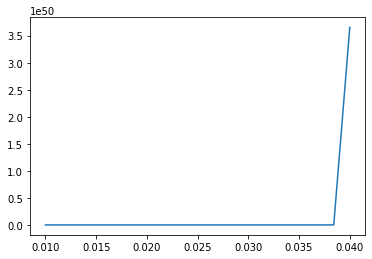

In [23]:
### a)

# Calling one simulator, animating and plotting
#simulator = MDsimulator()
#anim = simulator.simulate_animate()
#simulator.plot_energy()

# Study the quality of the integration by monitoring the drift in the total energy for several different time steps just before things go wrong.

dt_list = np.linspace(0.01, 0.04, 20)
std_list = []
cv_values = []

cnt = 0
for dt in dt_list:
    print(f"loop: {cnt/len(dt_list)}")
    cnt += 1
    simulator = MDsimulator(dt=dt, nsteps=10000, T=1)
    simulator.simulate()
    cv_values.append(simulator.Cv)
    std_list.append(np.std(simulator.etotList))
# TODO
# Plotting and analyzing results ...

print(cv_values)
plt.plot(dt_list, std_list)
plt.show()

[0.0046416707182838565, 0.0, 2.85449538541192e+45, 1.361129467683754e+39, 0.0] [0.01  0.045 0.08  0.115 0.15 ]


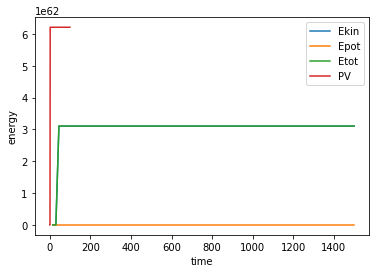

In [22]:
print(std_list, dt_list)
simulator.plot_energy()

T=1, integrating for 20000 steps ...
time 10.0 <Cv> = 5.6811636557737716e+23 <P>V = -4.63994949638345
0.05
time 20.0 <Cv> = 3.707567626102595e+23 <P>V = -3.404530106524347
0.1
time 30.0 <Cv> = 2.907482881911893e+23 <P>V = -1.5133723613419243
0.15
time 40.0 <Cv> = 2.398085182300934e+23 <P>V = -2.346173443509555
0.2
time 50.0 <Cv> = 2.07373543528965e+23 <P>V = -2.7293893197107355
0.25
time 60.0 <Cv> = 1.9165549239031724e+23 <P>V = -1.3048050013156682
0.3
time 70.0 <Cv> = 1.7849258841927656e+23 <P>V = -1.9000193390498314
0.35
time 80.0 <Cv> = 1.6580534409615493e+23 <P>V = -1.9248858242675055
0.4
time 90.0 <Cv> = 1.5662122344201783e+23 <P>V = -1.8338414481936043
0.45
time 100.0 <Cv> = 1.4782788384050325e+23 <P>V = -1.6887720211148147
0.5
time 110.0 <Cv> = 1.4806548225464623e+23 <P>V = -1.8625867360040533
0.55
time 120.0 <Cv> = 1.4221575471237025e+23 <P>V = -1.913946089126784
0.6
time 130.0 <Cv> = 1.3837116321334128e+23 <P>V = -2.407556720890285
0.65
time 140.0 <Cv> = 1.3427617170169313e+23

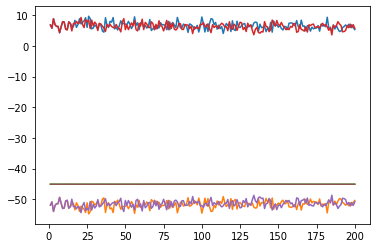

In [8]:
### b)

sim1 = MDsimulator(T=1)
sim2 = MDsimulator(T=0.2)

sim1.simulate()
sim2.simulate()

plt.figure()
plt.plot(sim1.outt, sim1.ekinList, sim1.outt, sim1.epotList, sim1.outt, sim1.etotList, label="T=1")
plt.plot(sim2.outt, sim2.ekinList, sim2.outt, sim2.epotList, sim2.outt, sim2.etotList, label="T=0.2")
plt.legend()
plt.plot()

In [ ]:
### c)

sim1 = MDsimulator(T=1, thermalize_func=thermalize2)
sim2 = MDsimulator(T=0.2, thermalize_func=thermalize2)

sim1.simulate()
sim2.simulate()

plt.figure()
plt.plot(sim1.outt, sim1.ekinList, sim1.outt, sim1.epotList, sim1.outt, sim1.etotList, label="T=1")
plt.plot(sim2.outt, sim2.ekinList, sim2.outt, sim2.epotList, sim2.outt, sim2.etotList, label="T=0.2")
plt.legend()
plt.plot()